In [1]:
%cd /qbio/ari/works/hcmv/hcmv_ont

/qbio/ari/works/hcmv/hcmv_ont


In [4]:
from Bio import SeqIO
import gzip
import pysam
import re
import h5py
import os

import sys
sys.path.append('/blaze/hyeshik/gh/poreplex')
#from poreplex import fast5_file

import pandas as pd
import numpy as np

from Bio import Seq
from Bio import SeqIO
import matplotlib.pyplot as plt


import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

In [8]:
viruschr = 'GU937742.2'
reference_sequence = '../refs/HCMV-Toledo.fasta'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [6]:
import re

homorep = re.compile('A+|G+|C+|T+')

def convert_flipflop_seq(seq): # Takes 5' -> 3' seq, returns flipflop-tagged 5' -> 3' seq
    ref = seq[::-1].upper()

    def flipflopcase(match):
        m = match.group()
        if len(m) == 1:
            return m # fast path
        return ''.join((c.lower() if i % 2 else c) for i, c in enumerate(m))

    return homorep.sub(flipflopcase, ref)[::-1]

refseqs_ff = {k: convert_flipflop_seq(v) for k, v in refseqs.items()}

In [7]:
sample_names = 'latent react lytic'.split(' ')
MIN_COV = 100
MIN_ODDR = 1.8
AGG_DIS = 4
MIN_MODFRAC = 0.3
MAX_PVALUE = 0.001

lnccolors = {
    'RNA2.7': [2362, 4874, '#82c91e', '-'],
    'RNA1.2': [6634, 7684, '#ffd43b', '-'],
    'RNA4.9': [93949, 98873, '#3bc9db', '+'],
    'RNA5.0': [155744,  161422 , '#e64980', '-'],
}

lncanno = pd.DataFrame(lnccolors,
                      index='start end color strand'.split(' '))
                      #columns=['name', 'start', 'end', 'color'])
lncanno = lncanno.T
lncanno

,start,end,color,strand
RNA2.7,2362,4874,#82c91e,-
RNA1.2,6634,7684,#ffd43b,-
RNA4.9,93949,98873,#3bc9db,+
RNA5.0,155744,161422,#e64980,-


In [9]:
def load_combine_all(filelist, samples):
    modfracs = []
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats)
    
    modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
    return(modfracs)

def get_modified_sites(filelist, samples, pvalue=0.05, hp_filter=True):
    positive_positions = set()
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        if hp_filter:
            stats = stats[stats['homo_seq']=='--']

        stats_high = stats[(stats['total_reads'] >= MIN_COV) &
                               (stats['oddR'] >= MIN_ODDR) &
                          (stats['pval']<=MAX_PVALUE)&
                          (stats['ESB_test']>=0.05)]
        positive_positions |= set(stats_high['start_loc'].tolist())
    
    modfracs=[]
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats[stats['start_loc'].isin(positive_positions)])
        
    
    if len(modfracs) > 0:
        ret = pd.concat(modfracs).sort_values(by=['start_loc', 'sample']).reset_index(drop=True)
        return ret

def aggregate_adjacent_sites(modfracs, max_distance, minimum_coverage):
    modsites_raw = sorted(modfracs['start_loc'].unique())
    continuity = np.diff(modsites_raw) <= max_distance

    modsite_groups = [[modsites_raw.pop(0)]]
    for pos, cont in zip(modsites_raw, continuity):
        if cont:
            modsite_groups[-1].append(pos)
        else:
            modsite_groups.append([pos])

    purified = []
    for modsites in modsite_groups:
        modfracsites = modfracs[modfracs['start_loc'].isin(modsites)]

        modfracsites_high = modfracsites[modfracsites['total_reads'] >= minimum_coverage]
        maxpos = modfracsites.loc[modfracsites_high['oddR'].idxmax()]
        purified.append(modfracsites[modfracsites['start_loc'] == maxpos['start_loc']])

    return pd.concat(purified)



modfracs = load_combine_all(
    [f'eligos2/pairdiff2/hcmv_{name}/combine.txt' for name in sample_names],
              sample_names)

eligos2_freqmods = get_modified_sites(
    [f'eligos2/pairdiff2/hcmv_{name}/combine.txt' for name in sample_names],
              sample_names, pvalue=MAX_PVALUE)



eligos2_psites = aggregate_adjacent_sites(eligos2_freqmods, AGG_DIS, MIN_COV)
def identify_position(p, anno):
    matching = anno[(anno['start']-1 <= p) & (p < anno['end']+1)]
    return(matching.index.tolist()[0])
def summarize_into_table(aggrtbl):
    mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['oddR'],
                                 index=['start_loc', 'strand']).fillna(0)['oddR'].copy()
    coverage = pd.pivot_table(aggrtbl, columns='sample', values=['total_reads'],
                             index=['start_loc', 'strand']).fillna(0)['total_reads'].copy()
    esb = pd.pivot_table(aggrtbl, columns='sample', values=['ESB_test'],
                             index=['start_loc', 'strand']).fillna(0)['ESB_test'].copy()
    return esb, mod_frac_all, coverage

def add_context_info(sitemodfrac, refseq, flanksize, lncanno):
    context_list=[]
    for pos, strand in sitemodfrac.index:

        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        if strand =='-':
            context = str(Seq.Seq(context).reverse_complement())
        else:
            context = context
        context_list.append(context)
        
    return(context_list)


eligos2_esb, eligos2_sitemodfrac, eligos2_sitecov= summarize_into_table(eligos2_psites)


eligos2_sitemodfrac['lnc'] = [identify_position(p,lncanno) for p in np.array(list(eligos2_sitemodfrac.index))[:,0].astype(int)]
eligos2_sitemodfrac['context'] = add_context_info(eligos2_sitemodfrac, refseq, 10, lncanno)
eligos2_sitemodfrac = eligos2_sitemodfrac.reset_index().set_index('start_loc')
eligos2_sitemodfrac[eligos2_sitemodfrac['lnc']!='RNA5.0']

sample,strand,latent,lytic,react,lnc,context
start_loc,,,,,,
2361,-,2.691567,5.512133,3.492105,RNA2.7,guuugcaugcAuuugccgugu
2452,-,1.997827,1.853122,2.040749,RNA2.7,uaaucuauuaUuuuguuccuu
2649,-,11.499408,12.129549,10.379227,RNA2.7,ucgugagaacUuugagauucg
2668,-,3.993043,4.166196,3.916033,RNA2.7,auucuugaagAcaauauucuc
2691,-,2.443807,2.988518,3.312116,RNA2.7,aaaaucuuggAccacaguugu
2709,-,6.007200,5.460003,6.289067,RNA2.7,accuaaaaagAccaaaaaaaa
2921,-,3.473871,3.048512,3.466441,RNA2.7,uacaccuagaGacagcccuua
3018,-,1.427286,1.795905,2.032633,RNA2.7,ccaaugcaauCuugucucggc
3037,-,1.147611,1.390942,1.864067,RNA2.7,cguuuuugaaAcaguucagcc


In [10]:
hotspot_seqs_ff = {}
for _, line in eligos2_sitemodfrac.iterrows():
    pos = _
    left = pos - 10
    right = pos +10
    strand = line['strand']
    if strand =='-':
        
        hotspot_seqs_ff[(line['lnc'], left, right, pos)] = str(Seq.Seq(refseqs_ff['GU937742.2'][left:right]).reverse_complement())
    else:
        hotspot_seqs_ff[(line['lnc'], left, right, pos)] = str(Seq.Seq(refseqs_ff['GU937742.2'][left:right]))
    

In [11]:
import subprocess as sp
import re

homorep = re.compile('A+|G+|C+|T+')

In [12]:
import sys
sys.path.append('/blaze/hyeshik/gh/fivetools')
from fivetools import fast5_file

ImportError: /blaze/ari/conda/envs/lab/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /blaze/ari/conda/envs/lab/lib/python3.8/site-packages/scipy/fft/_pocketfft/pypocketfft.cpython-38-x86_64-linux-gnu.so)

In [13]:
FAST5PREFIX = f'guppy_subset/hcmv_latent_1/'
seqsummary = pd.read_csv(f'{FAST5PREFIX}/sequencing_summary.txt',
                         sep='\t', low_memory=False)

In [14]:
NANOPOLISH_EVENTALIGN_COLUMNS = """ 
contig position reference_kmer read_name strand
event_index event_level_mean event_stdv event_length model_kmer
model_mean model_stdv standardized_level start_idx end_idx""".split()

In [15]:
FLANKING_WIDTH = 10

In [16]:
 # one-side, # bases

def get_signal_ranges(pos, sample):
    # Where does "2" come from? --> XXX
    start = pos - FLANKING_WIDTH
    end = pos + FLANKING_WIDTH
    
    dfs=[]
    
    if sample in ['latent', 'react']:

        for i in range(1,3):

            with sp.Popen(['tabix',
                           f'nanopolish/hcmv_{sample}_{i}/alignments.txt.gz',
                           f'{viruschr}:{start}-{end}'], stdout=sp.PIPE) as proc:
                df= pd.read_csv(proc.stdout, sep='\t', names=NANOPOLISH_EVENTALIGN_COLUMNS,
                                 low_memory=False)
                dfs.append(df)
    else:
        with sp.Popen(['tabix',
                           f'nanopolish/hcmv_{sample}_1/alignments.txt.gz',
                           f'{viruschr}:{start}-{end}'], stdout=sp.PIPE) as proc:
            df = pd.read_csv(proc.stdout, sep='\t', names=NANOPOLISH_EVENTALIGN_COLUMNS,
                            low_memory=False)
            dfs.append(df)
        
    dfs = pd.concat(dfs)
    
    kmerspans = dfs.groupby('read_name').agg({
        'start_idx': 'min',
        'end_idx': 'max',
        'position': lambda x: len(x.unique())})
    kmerspans.columns = ['start', 'end', 'span']
    return kmerspans

In [17]:
match_all = []
for pos in [2691, 2921, 3771, 4276, 6649, 6670, 6940, 7011, 97089, 97603]:
    for sample in 'latent react lytic ivt'.split(' '):
        matches = get_signal_ranges(pos, sample)
        matches['pos'] = pos
        matches['sample'] = sample
        match_all.append(matches)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [18]:
match_all = pd.concat(match_all)
matches_purif = match_all[match_all['span'] == 21].copy()

In [21]:
rawsignals = {}
tracesignals = {}


In [23]:
def gettrace(pos, sample, i, path):
    tempmatch = matches_purif[(matches_purif['pos']==pos)&
                                 (matches_purif['sample']==sample)]
    if f'{sample}_{pos}' not in rawsignals.keys():
        rawsignals[f'{sample}_{pos}'] = []
        
    if f'{sample}_{pos}' not in tracesignals.keys():
        tracesignals[f'{sample}_{pos}'] = []
        

    FAST5PREFIX = f'raw_link/hcmv_{sample}_{i}/'
    seqsummary = pd.read_csv(f'raw_link/hcmv_{sample}_{i}/sequencing_summary.txt',
                                    sep='\t', low_memory=False)

    seqmatched = pd.merge(tempmatch, 
                          seqsummary, 
                          left_index=True, right_on='read_id')


    for _, row in seqmatched.iterrows():
        print('.', end='', file=sys.stdout)
        fast5path = os.path.join(FAST5PREFIX, 'workspace', path, row['filename'])
        try:
            with fast5_file.Fast5Reader(fast5path, row['read_id']) as f5:
                rnode = f5.handle[f5.read_node.split('/')[0]]

                segnode = max((name, node)
                              for name, node in rnode['Analyses'].items() if name.startswith('Segmentation_'))[1]
                segsummary = dict(segnode['Summary/segmentation'].attrs)
                # {'adapter_max': 0.0, 'duration_template': 51488, 'first_sample_template': 11930,
                #  'has_complement': 0, 'has_template': 1, 'med_abs_dev_template': 14.006962,
                #  'median_template': 96.263535, 'num_events_template': 3432, 'pt_detect_success': 0,
                #  'pt_median': 0.0, 'pt_sd': 0.0}
        #        print(segsummary)

                bcallnode = max((name, node)
                                for name, node in rnode['Analyses'].items() if name.startswith('Basecall_1D_'))[1]
                bcallsummary = dict(bcallnode['Summary/basecall_1d_template'].attrs)
                # {'block_stride': 15, 'called_events': 3432, 'mean_qscore': 8.658701,
                #  'scaling_mean_abs_dev': 14.006962, 'scaling_median': 96.263535, 'sequence_length': 722,
                #  'skip_prob': 0.0, 'stay_prob': 0.7896271, 'step_prob': 0.21037297, 'strand_score': 0.0}

                stride = bcallsummary['block_stride']
                sample_start = segsummary['first_sample_template']

                trace_start = int((row['start'] - sample_start) // stride)
                trace_end = int((row['end'] - row['start']) // stride) + trace_start
                if trace_start < 0:
                    print(f'Trace out of range: {row[read_id]}')
                    continue

                traceattrs = dict(bcallnode['BaseCalled_template/Trace'].attrs) #{'offset': 0.0, 'scale': 0.003921569, 'table_version': b'flipflop_trace_table_v0.1'}
                tracedata = pd.DataFrame(bcallnode['BaseCalled_template/Trace'][trace_start:trace_end]).astype(np.float32)
                tracedata = tracedata * traceattrs['scale'] + traceattrs['offset']

                tracesignals[f'{sample}_{pos}'].append(tracedata)

                rawdata = f5.get_raw_data(start=row['start'], end=row['end'])
                rawsignals[f'{sample}_{pos}'].append(rawdata)

                if len(tracesignals[f'{sample}_{pos}']) >= 1000:
                    break
                
        except:
            continue
            

    print(' - done', file=sys.stdout)
    

In [ ]:
for pos in [7011, 4276, 97603]:
    gettrace(pos, 'latent', 1, '')
    gettrace(pos, 'latent', 2, 'fast5_pass')
    gettrace(pos, 'react', 1, 'fast5')
    gettrace(pos, 'react', 2, '20210218_0701_MN22348_FAP28104_13635f93/fast5_pass')
    gettrace(pos, 'lytic', 1, '20210419_0617_MN35732_FAP28118_961dd4af/fast5_pass')
    gettrace(pos, 'ivt', 1, 'fast5_pass')
    

In [ ]:
import pickle


with open('pickle/rawsignals_0114.pickle', 'wb') as f:
    pickle.dump(rawsignals, f)
with open('pickle/tracesignals_0114.pickle', 'wb') as f:
    pickle.dump(tracesignals, f)

In [48]:

with open('pickle/rawsignals_0114.pickle', 'rb') as f:
    rawsignals = pickle.load(f)
    
with open('pickle/tracesignals_0114.pickle', 'rb') as f:
    tracesignals = pickle.load(f)

In [24]:
import re

homorep = re.compile('A+|G+|C+|T+')

In [25]:
np.set_printoptions(linewidth=120)

In [26]:
stride=15

In [27]:
class FlipFlopMapper:

    def __init__(self, stay_prob=0.75, step_prob=0.2, skip_prob=0.05, basal_prob=0.01):
        self.stay_prob = stay_prob
        self.step_prob = step_prob
        self.skip_prob = skip_prob
        self.basal_prob = basal_prob

    def fit(self, seq, trace):
        ffref = self.convert_flipflop_seq(seq)
        
        trace = self.adopt_trace_table(trace)
        eventmap = self.warp(ffref, trace)
        # Invert reference positions for RNA
        eventmap['ref'] = len(seq) - 1 - eventmap['ref']
        return eventmap

    def convert_flipflop_seq(self, seq):
        ref = seq[::-1].upper()

        def flipflopcase(match):
            m = match.group()
            if len(m) == 1:
                return m # fast path
            return ''.join((c.lower() if i % 2 else c) for i, c in enumerate(m))

        return homorep.sub(flipflopcase, ref)

    def warp(self, ffref, trace):
        S = np.zeros([len(trace) + 1, len(ffref) + 1], dtype=np.float32)
        T = np.zeros([len(trace) + 1, len(ffref) + 1], dtype=np.int32)
        for i in range(1, len(trace) + 1):
            S[i, 0] = -np.inf
            T[i, 0] = 0
        for j in range(1, len(ffref) + 1):
            S[0, j] = j * np.log2(self.skip_prob)
            T[0, j] = 2

        # Build score table
        for i, bcall in trace.iterrows():
            i += 1
            bcall += self.basal_prob
            bcall = np.log2(bcall / bcall.sum())

            for j, refev in enumerate(ffref, 1):
                bcallmatch = bcall.loc[refev]

                score_stay = np.log2(self.stay_prob) + bcallmatch + S[i - 1, j]
                score_step = np.log2(self.step_prob) + bcallmatch + S[i - 1, j - 1]
                score_skip = np.log2(self.skip_prob) + S[i, j - 1]
                scores = [score_stay, score_step, score_skip]
                
                optpath = np.argmax(scores)
                S[i, j] = scores[optpath]
                T[i, j] = optpath # 0: stay, 1: step, 2: skip

        # Backtrace the optimal path
        Bi, Bj = len(trace), len(ffref)
        pairs = []
        while Bi > 0 or Bj > 0:
            optpath = T[Bi, Bj]
            if optpath == 2: # skip
                Bj -= 1
                pairs.append((-1, Bj))
            elif optpath == 1: # step
                Bi -= 1
                Bj -= 1
                pairs.append((Bi, Bj))
            elif optpath == 0: # stay
                Bi -= 1
                pairs.append((Bi, Bj - 1))
            else:
                raise RuntimeError

        eventmap = pd.DataFrame(pairs, columns=['trace', 'ref'], dtype=np.int32)

        return eventmap

    def adopt_trace_table(self, orig):
        orig.columns = ['A', 'C', 'G', 'U', 'a', 'c', 'g', 'u']
        return orig

refseq = eligos2_sitemodfrac.loc[4276]['context']
mapper = FlipFlopMapper()

In [28]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

In [29]:
from itertools import cycle

In [31]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

1000


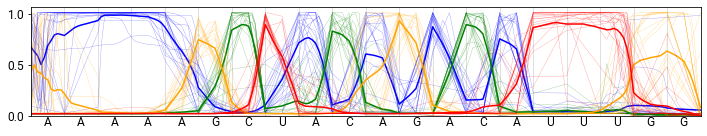

In [46]:
def plot_trace(pos, sample, ax):
    tracecolors = ['blue', 'green', 'orange', 'red', 'blue', 'green', 'orange', 'red']
    tracels = ['-', '-', '-', '-', '--', '--', '--', '--']

    rsigs = rawsignals[f'{sample}_{pos}']
    traces = tracesignals[f'{sample}_{pos}']
    
    bases = 'A C G U'.split(' ')
    basecolors = {
        'A': 'blue',
        'C': 'green',
        'G': 'orange',
        'U': 'red',
        'a': 'blue',
        'c': 'green',
        'g': 'orange',
        'u': 'red'
    }
    refseq = eligos2_sitemodfrac.loc[pos]['context']
    
    length = len(traces)
    print(length)
    

    
    resolution = 10
    randomchoice = 20
    
    #fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    
    np.random.seed(2022)
    #for i in np.random.choice(length, randomchoice, replace=False):

    #    rsig = rsigs[i].copy()
    #    trace = traces[i].copy()
        
    #    for j, base in enumerate(bases):
    for j, base in enumerate(bases):
        
        resqs = []
        for i in np.random.choice(length, randomchoice, replace=False):
            rsig = rsigs[i].copy()
            trace = traces[i].copy()
            
            
            try:
            #ax = axes
                ffmap = mapper.fit(refseq, trace)
                trace_base = trace[base]+trace[base.lower()]
                trace_base = trace_base[::-1]


                trace_ = []
                base_pos_ = []
                dwell_ = []

                for p, t in ffmap.groupby('ref'):
                    section = len(t)
                    if t['trace'].iloc[0] ==-1:

                        trace_.extend([0]*section)
                        #dwell_.append(0)
                        base_pos_.extend(np.arange(p+pos-FLANKING_WIDTH, p+pos-FLANKING_WIDTH+1, 1/section))
                    else:
                        trace_.extend(trace_base[:section])
                        base_pos_.extend(np.arange(p+pos-FLANKING_WIDTH, p+pos-FLANKING_WIDTH+1, 1/section))
                        trace_base = trace_base[section:]


                newxpos = np.linspace(pos-FLANKING_WIDTH, pos+FLANKING_WIDTH, resolution*(len(refseq)-1)+1)

                interp=interp1d(base_pos_, trace_, fill_value='extrapolate')
                resq_trace_=interp(newxpos)
                resqs.append(resq_trace_)
                ax.plot(newxpos, resq_trace_, 
                    alpha=.5, lw=.3, color=basecolors[base])
                #ax.plot(base_pos_, trace_, 
                #    alpha=.5, lw=.4, color=basecolors[base])
            except:
                continue
        resqs = np.array(resqs)
        
        #print(resqs.mean(axis=0))
        ax.plot(newxpos, resqs.mean(axis=0), color=basecolors[base])
   



            #interp = interp1d(base_pos_, signal_, fill_value='extrapolate')
            #resq_signal_ = interp(newxpos)
          
            
            #ax.set_ylabel(base)
    for i, base in enumerate(refseq):
        ax.annotate(base.upper(), (i+pos-FLANKING_WIDTH+.5, 0), ha='center', va='top')
        ax.axvline(pos-FLANKING_WIDTH+i, alpha=.5, zorder=0, lw=.5, color='grey')
    ax.set_xlim(pos-FLANKING_WIDTH, pos+FLANKING_WIDTH)
    ax.set_ylim(0,)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklines(), visible=False)

    
    #ax.set_ylim(1,2)  
    
    
        


    #ax.set_xlim(0, len(rsig) / stride)
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    
plot_trace(4276, 'lytic', ax)

In [37]:
from Bio.Cluster import treecluster
def similarity_sort(signals):
    tree= treecluster(signals, dist='c')
    pushed = {}
    def resolve(idx):
        if idx < 0:
            getting = pushed[idx]
            del pushed[idx]
            return getting
        else:
            return [idx]

    for i in range(len(tree)):
        node = tree[i]
        clsi = -i-1
        pushed[clsi] = resolve(node.left) + resolve(node.right)

    return next(iter(pushed.values()))

['U', 'C', 'A']
1000
(20, 200, 3)


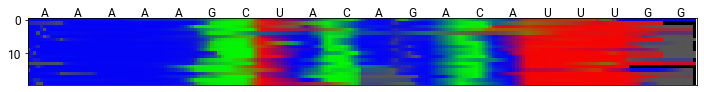

In [49]:
def heat_RGB(pos, sample, ax, nonbase):

    rsigs = rawsignals[f'{sample}_{pos}']
    traces = tracesignals[f'{sample}_{pos}']
    
    bases = 'G U C A'.split(' ')
    bases.remove(nonbase)
    print(bases)

    refseq = eligos2_sitemodfrac.loc[pos]['context']
    
    length = len(traces)
    print(length)

    resolution = 10
    randomchoice = 20
    

    np.random.seed(2022)
      
    #resqs = []
    rgb = []
    for i in np.random.choice(length, randomchoice, replace=False):
        rsig = rsigs[i].copy()
        trace = traces[i].copy()


        try:
        #ax = axes
            ffmap = mapper.fit(refseq, trace)

            trace_0= trace[bases[0]]+trace[bases[0].lower()]
            trace_1= trace[bases[1]]+trace[bases[1].lower()]
            trace_2= trace[bases[2]]+trace[bases[2].lower()]
            #trace_3= trace[bases[3]]+trace[bases[3].lower()]
            
            trace_0 = trace_0[::-1]
            trace_1 = trace_1[::-1]
            trace_2 = trace_2[::-1]
            #trace_3 = trace_3[::-1]


            trace_0_ = []
            trace_1_ = []
            trace_2_ = []
            #trace_3_ = []
            
            base_pos_ = []
            

            for p, t in ffmap.groupby('ref'):
                section = len(t)
                if t['trace'].iloc[0] ==-1:

                    trace_0_.extend([0]*section)
                    trace_1_.extend([0]*section)
                    trace_2_.extend([0]*section)
                    #trace_3_.extend([0]*section)
                    
                    #dwell_.append(0)
                    base_pos_.extend(np.arange(p+pos-FLANKING_WIDTH, p+pos-FLANKING_WIDTH+1, 1/section))
                else:
                    trace_0_.extend(trace_0[:section])
                    trace_1_.extend(trace_1[:section])
                    trace_2_.extend(trace_2[:section])
                    
                    
                    base_pos_.extend(np.arange(p+pos-FLANKING_WIDTH, p+pos-FLANKING_WIDTH+1, 1/section))
                    trace_0 = trace_0[section:]
                    trace_1 = trace_1[section:]
                    trace_2 = trace_2[section:]


            newxpos = np.linspace(pos-FLANKING_WIDTH, pos+FLANKING_WIDTH, resolution*(len(refseq)-1))

            interp=interp1d(base_pos_, trace_0_, fill_value='extrapolate')
            resq_trace_0_=interp(newxpos)
            
            interp=interp1d(base_pos_, trace_1_, fill_value='extrapolate')
            resq_trace_1_=interp(newxpos)
            
            interp=interp1d(base_pos_, trace_2_, fill_value='extrapolate')
            resq_trace_2_=interp(newxpos)
            
            resqs = np.array([resq_trace_0_,
                    resq_trace_1_,
                    resq_trace_2_])
            resqs = resqs.T
            
            rm = resqs.sum(axis=1)
            

            c=np.divide(255, resqs.sum(axis=1), out=np.zeros_like(rm),
                        where=rm!=0).reshape(len(rm),1)
            

            resqs = resqs*c

            rgb.append(resqs)
            

        except:
            continue
    
    rgb = np.array(rgb, dtype=np.uint8)
    

    print(rgb.shape)
    
    #im = ax.imshow(rgb)
    #print(rgb.reshape(20,603))
    
    sortedorder = similarity_sort(rgb.reshape(rgb.shape[0], 600))
    
    
    jsrgb = rgb[sortedorder]
    im = ax.imshow(jsrgb)
            #interp = interp1d(base_pos_, signal_, fill_value='extrapolate')
            #resq_signal_ = interp(newxpos)
          
            
            #ax.set_ylabel(base)
    anno = rgb.shape[0]
    for i, base in enumerate(refseq):
        ax.annotate(base.upper(), ((i+.5)*resolution, 0), 
                    ha='center', va='bottom')
        #ax.axvline(pos-FLANKING_WIDTH+i, alpha=.5, zorder=0, lw=.5, color='grey')
    #ax.set_xlim(pos-FLANKING_WIDTH, pos+FLANKING_WIDTH)
    #ax.set_ylim(0,)
    ax.set_xlim(0, len(refseq)*resolution-resolution)
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_xticklines(), visible=False)


    
    #ax.set_ylim(1,2)  
    
    
        


    #ax.set_xlim(0, len(rsig) / stride)
fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    
heat_RGB(4276, 'lytic', ax, 'G')

1000
1000
1000
1000


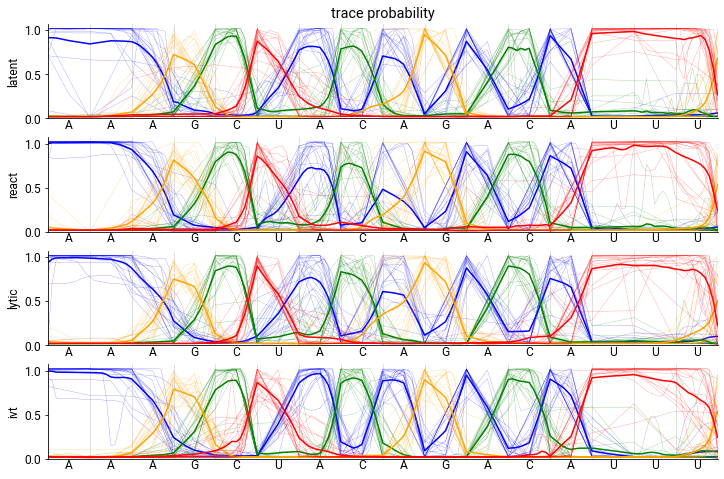

In [39]:
def plot_traceall(pos):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    plot_trace(pos, 'latent', axes[0])
    plot_trace(pos, 'react', axes[1])
    plot_trace(pos, 'lytic', axes[2])
    plot_trace(pos, 'ivt', axes[3])
    
    axes[0].set_title('trace probability')
    for i, sample in enumerate(sample_names):
        ax = axes[i]
        ax.set_ylabel(sample)
    for i in range(4):
        ax = axes[i]
        ax.set_ylim(0)
        for sp in 'top right'.split():
            ax.spines[sp].set_visible(False)
        ax.set_xlim(pos-8, pos+8)

    axes[3].set_ylabel('ivt')
    
    return(fig, axes)
        
    
fig, axes = plot_traceall(4276)

['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)


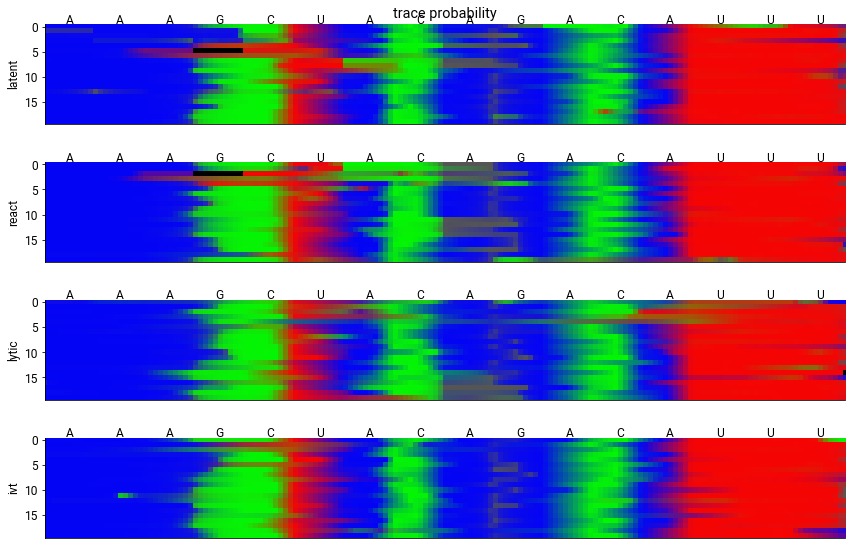

In [50]:
def heat_RGBall(pos, nonbase):
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    heat_RGB(pos, 'latent', axes[0], nonbase)
    heat_RGB(pos, 'react', axes[1], nonbase)
    heat_RGB(pos, 'lytic', axes[2], nonbase)
    heat_RGB(pos, 'ivt', axes[3], nonbase)
    
    axes[0].set_title('trace probability')
    for i, sample in enumerate(sample_names):
        ax = axes[i]
        ax.set_ylabel(sample)
        
    for i in range(4):
        ax = axes[i]
        ax.set_xlim(2*10, 18*10)
        for sp in 'top right'.split():
            ax.spines[sp].set_visible(False)

    axes[3].set_ylabel('ivt')
    
    return(fig, axes)
        
    
fig, axes = heat_RGBall(4276, 'G') 
plt.tight_layout()

['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)


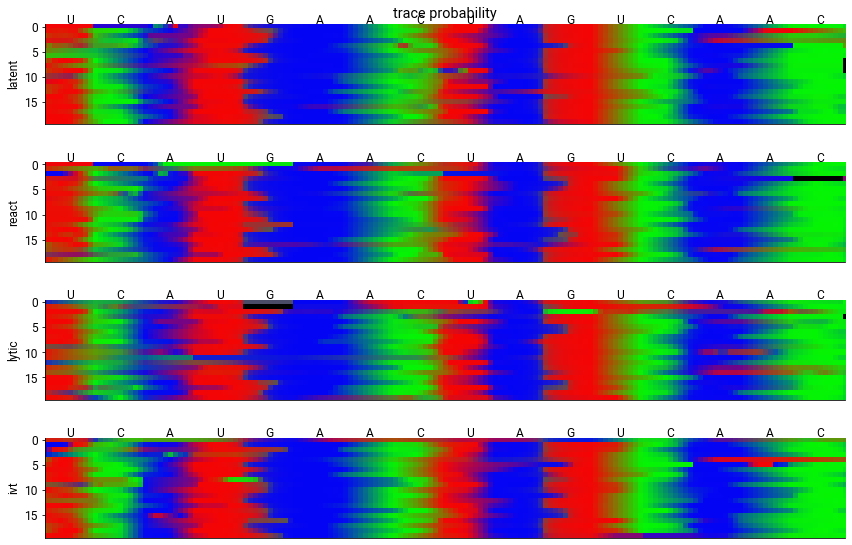

In [51]:
fig, axes = heat_RGBall(7011, 'G') 
plt.tight_layout()

['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
383
(19, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)
['U', 'C', 'A']
1000
(20, 200, 3)


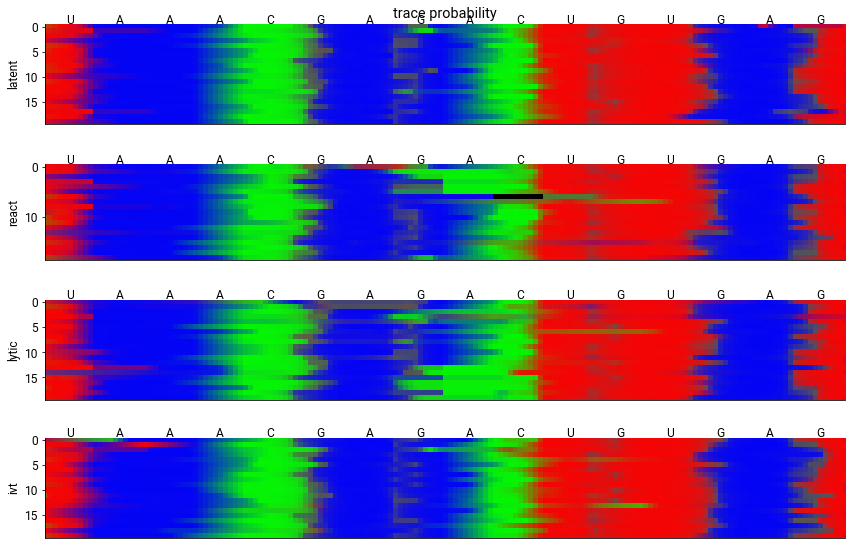

In [52]:
fig, axes = heat_RGBall(97603, 'G') 
#fig, axes = heat_tracebaseall(4276, 'A')
plt.tight_layout()

1000
1000
1000
1000


(<Figure size 864x576 with 4 Axes>,
 array([<AxesSubplot:title={'center':'trace probability'}, ylabel='latent'>, <AxesSubplot:ylabel='react'>,
        <AxesSubplot:ylabel='lytic'>, <AxesSubplot:ylabel='ivt'>], dtype=object))

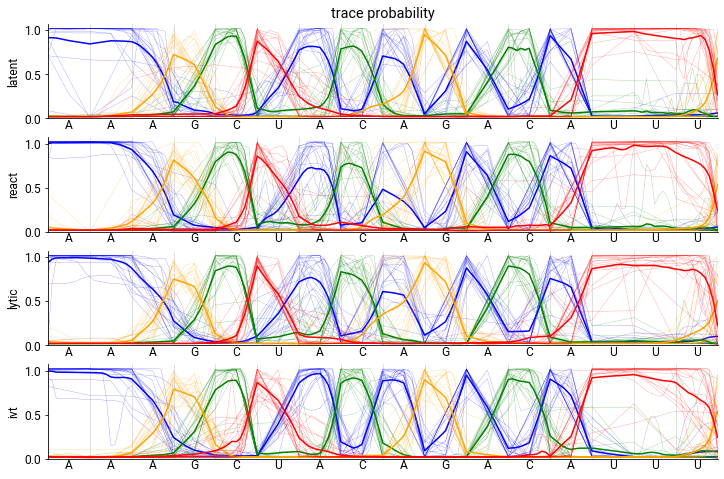

In [53]:
plot_traceall(4276)

In [ ]:
fig, axes = plot_traceall(97603)

1000
383
1000


In [ ]:
fig, axes = plot_traceall(7011)